# Calculate RMSSD for each stimuli

In [14]:
import numpy as np
import pandas as pd
import json

def rmssd_from_rr(rr_ms: pd.Series) -> float:
    rr = rr_ms.dropna().values.astype(float)
    if len(rr) < 2:
        return np.nan
    diff = np.diff(rr)
    return np.sqrt(np.mean(diff**2))

# load merged experiment JSON
with open("experiment_with_heart_rate.json", "r", encoding="utf-8") as f:
    participants = json.load(f)

rows = []
for p in participants:
    pid = p["participant_id"]

    for stim in p["stimuli"]:
        vid_id = stim["video_id"]
        stim_id = stim["id"]

        hr_rows = stim.get("heart_rate", [])
        if not hr_rows:
            rmssd_ms = np.nan
        else:
            df_hr = pd.DataFrame(hr_rows)

            if "ArtifactCorrectedRR" not in df_hr.columns or "ts" not in df_hr.columns:
                rmssd_ms = np.nan
            else:
                df_hr["ts"] = pd.to_datetime(df_hr["ts"], errors="coerce")
                df_hr = df_hr.dropna(subset=["ts", "ArtifactCorrectedRR"]).sort_values("ts")

                rmssd_ms = rmssd_from_rr(df_hr["ArtifactCorrectedRR"])

        # participant's belief from JSON
        belief = stim.get("video_response", {}).get("belief")

        rows.append({
            "participant_id": pid,
            "stim_id": stim_id,
            "video_id": vid_id,
            "belief": belief,
            "RMSSD_ms": rmssd_ms,
            "RMSSD_seconds": rmssd_ms / 1000.0 if pd.notna(rmssd_ms) else np.nan,
        })

rmssd_df = pd.DataFrame(rows)
rmssd_df.to_csv("rmssd_per_video.csv", index=False)

rmssd_df


,participant_id,stim_id,video_id,belief,RMSSD_ms,RMSSD_seconds
0,1,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,6.574545,0.006575
1,1,2,5768645-uhd_3840_2160_25fps.mp4,Human Generated,3.438652,0.003439
2,1,3,18840567-hd_1920_1080_30fps.mp4,AI Generated,9.997244,0.009997
3,1,4,11946387_3840_2160_30fps.mp4,AI Generated,11.292927,0.011293
4,2,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,9.658932,0.009659
...,...,...,...,...,...,...
83,22,4,5768645-uhd_3840_2160_25fps.mp4,AI Generated,56.831514,0.056832
84,23,1,18840567-hd_1920_1080_30fps.mp4,Human Generated,22.854238,0.022854
85,23,2,11946387_3840_2160_30fps.mp4,Human Generated,20.940313,0.020940
86,23,3,5768645-uhd_3840_2160_25fps.mp4,AI Generated,18.186405,0.018186


# Check for normal distribution

### Standardizing to remove accidental whitespace

In [15]:
rmssd_df["belief"] = rmssd_df["belief"].str.strip()


compute participant-level means

In [16]:
mean_table = (
    rmssd_df
    .pivot_table(
        index="participant_id",
        columns="belief",
        values="RMSSD_ms",
        aggfunc="mean"
    )
)


In [17]:
mean_table.head()


belief,AI Generated,Human Generated
participant_id,,
1,10.645085,5.006598
2,3.578088,9.311638
3,6.662976,8.779479
4,8.045195,8.636253
5,34.138333,32.273139


### Compute within-subject difference

In [18]:
mean_table["diff"] = (
    mean_table["AI Generated"] - mean_table["Human Generated"]
)


In [19]:
diff_values = mean_table["diff"].dropna().values
diff_values


array([  5.63848728,  -5.73354988,  -2.11650353,  -0.59105766,
         1.86519416,  -5.96526816, -24.20710311,   3.75876633,
        -0.29930797,   2.71818894,   0.34820696,   1.84202524,
        -3.94972202,  -3.22820498,  -0.05327738,  -5.64336467,
        33.37298077,  -5.39729539,   6.11462245,   4.43791795,
       -13.43307726,  -2.76179162])

### Plot the distribution

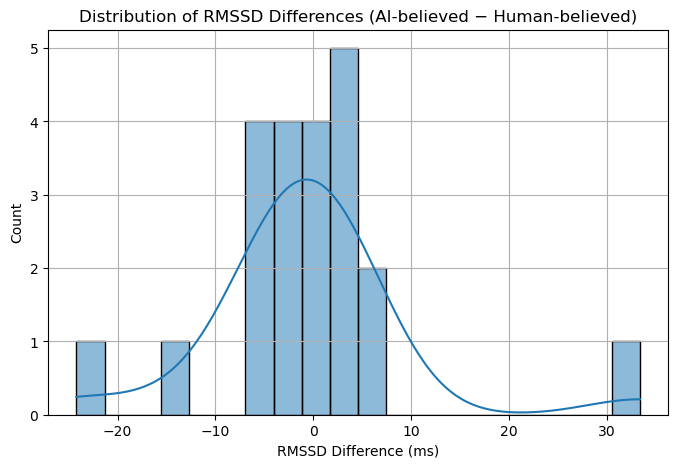

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(diff_values, kde=True, bins=20)
plt.title("Distribution of RMSSD Differences (AI-believed − Human-believed)")
plt.xlabel("RMSSD Difference (ms)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


### 4. Shapiro–Wilk Normality Test

In [21]:
from scipy.stats import shapiro

stat, p = shapiro(diff_values)

print(f"Shapiro-Wilk Test statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("✔ Differences appear normally distributed (fail to reject H0)")
else:
    print("✖ Differences are NOT normally distributed (reject H0)")


Shapiro-Wilk Test statistic: 0.8176
p-value: 0.0010
✖ Differences are NOT normally distributed (reject H0)


### QQ Plot for RMSSD Differences

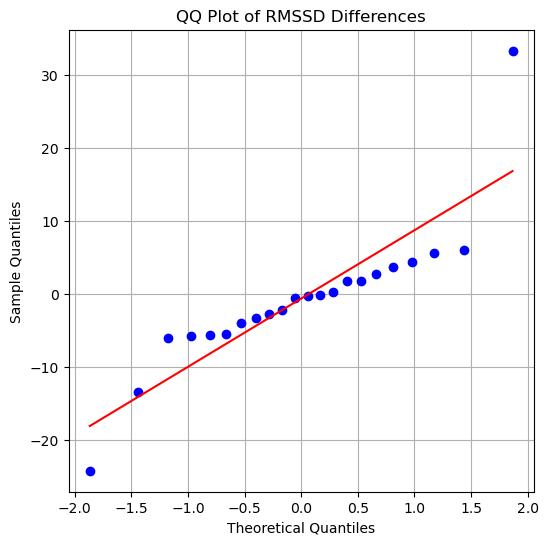

In [22]:
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
stats.probplot(diff_values, dist="norm", plot=plt)
plt.title("QQ Plot of RMSSD Differences")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()


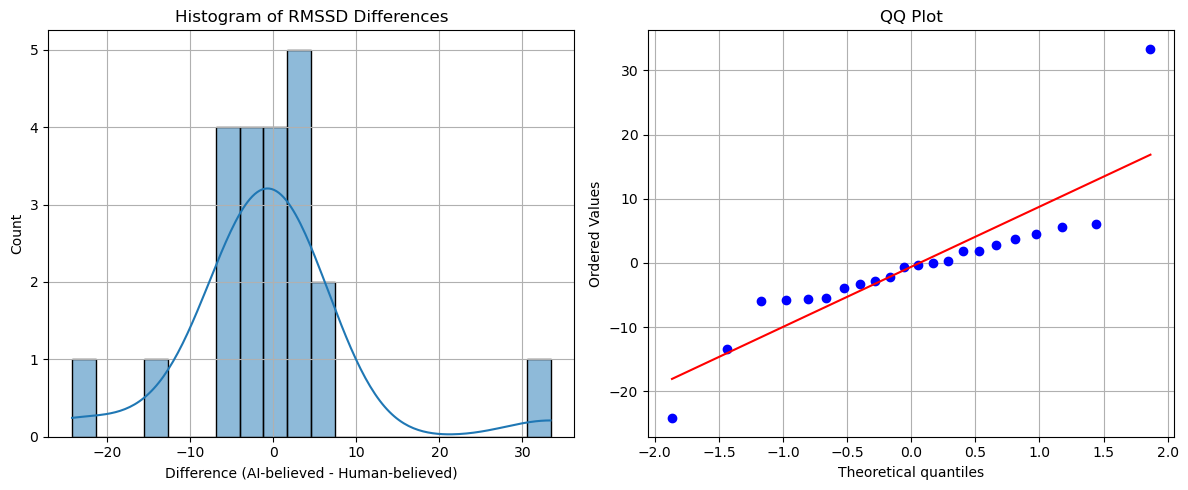

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram + KDE
sns.histplot(diff_values, kde=True, ax=ax[0], bins=20)
ax[0].set_title("Histogram of RMSSD Differences")
ax[0].set_xlabel("Difference (AI-believed - Human-believed)")
ax[0].grid(True)

# QQ Plot
stats.probplot(diff_values, dist="norm", plot=ax[1])
ax[1].set_title("QQ Plot")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# --- Add Wilcoxon signed-rank test on participant-level means ---
import numpy as np
from scipy.stats import wilcoxon

# use pivot result
# mean_table is created earlier in this notebook
paired = mean_table[["AI Generated", "Human Generated"]].dropna()
ai_vals = paired["AI Generated"].values
human_vals = paired["Human Generated"].values

# Wilcoxon signed-rank (two-sided)
stat, p = wilcoxon(ai_vals, human_vals, alternative="two-sided", zero_method="wilcox")
n = len(ai_vals)

# approximate effect size r from z
expected_W = n * (n + 1) / 4.0
std_W = np.sqrt(n * (n + 1) * (2 * n + 1) / 24.0)
z = (stat - expected_W) / std_W if std_W > 0 else np.nan
r = z / np.sqrt(n) if n > 0 else np.nan

print(f"n = {n}")
print(f"Wilcoxon W = {stat:.3f}, p = {p:.4f}")
print(f"approx. z = {z:.3f}, effect size r = {r:.3f}")

# also print medians and median difference for context
median_ai = np.median(ai_vals)
median_human = np.median(human_vals)
median_diff = np.median(ai_vals - human_vals)
print(f"median AI = {median_ai:.3f}, median Human = {median_human:.3f}, median(AI - Human) = {median_diff:.3f}")

# Interpretation hint:
# If p < 0.05, reject null of no median difference (two-sided).